# ASTR 596: The Midterm

#### 5 parts, 20 pts each. Some parts are easier than others, so are essentially free points, but you'll need to solve the earlier parts correctly to get the right answer on the later parts. I'd strongly recommend skimming the Riess et al. 2011 paper. 

#### We've been building up our ability to deal with complex data, and you've now got the ability to fit straight lines with frequentist tools (as you did with the Cepheids), and infer constraints on more complex high-dimensional models given the data with MCMC. So let's combine the two and infer one of the most important numbers in the Universe - the Hubble constant.

#### There are measurements of several Cepheid variable stars in each of 9 nearby galaxies.

#### Begin by reading this code and familiarizing yourself with what attributes and functions are available to you. In particular, it will help to read comments at the top of the data file `R11ceph.dat`.

In [1]:
exec(open('cepheids.py').read())
ceph = Cepheids('R11ceph.dat')
hosts = ceph.list_hosts()

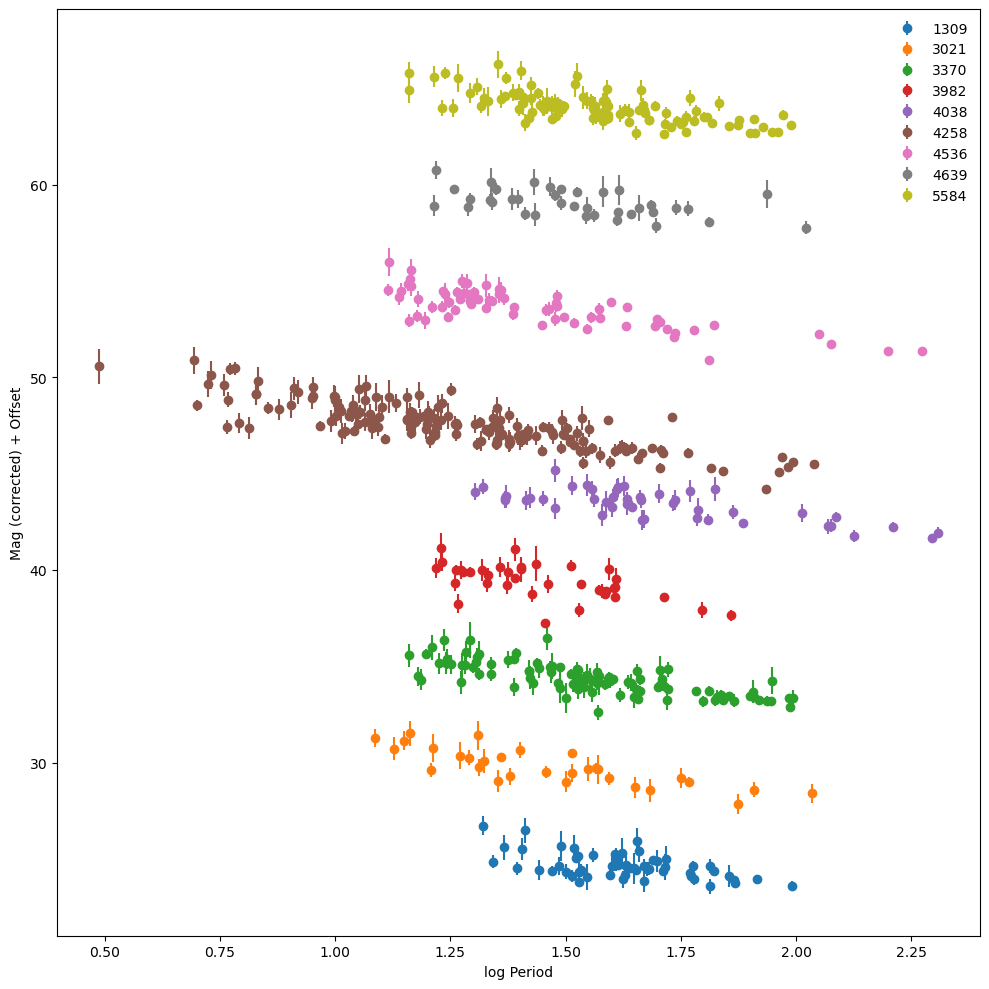

In [2]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs + 5 * i, yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset')
fig.tight_layout()

# Q1.

## This data was taken from [Riess et al., 2011](https://arxiv.org/abs/1103.2976)

## The global model for the magnitudes of these Cepheids is given in Equation 1. You may ignore the effect of metalicity

## Some parameters (such as distance intercept) are specific to each galaxy.

## Others are common to all galaxies. 

## Assuming Gaussian magnitude errors and no period error (and you may ignore metallicity entirely), but that Cepheids scatter off the period-luminosity relation because of some Gaussian intrinsic dispersion $\sigma_{\text{int}}$, write down your expression for the likelihood being careful to use the same indices that Riess et. al used.


<div style="color: DodgerBlue">

The model for the magnitude of the $j$-th object in the $i$-th galaxy is given as
$$
m_{i,j,\text{model}}=\Delta\mu_{i}+zp_{\text{W},4258}+b_{\text{W}}\log_{10}P_{i,j},
$$
where I define $\Delta\mu_{i}\equiv\mu_{0,i}-\mu_{0,4258}$ for brevity. Since our data has 9 galaxies including NGC4258, we therefore have 10 model parameters (since $\Delta\mu_{4258}=0$). The likelihood is
$$
L\propto\prod_{i}\prod_{j}\exp\left[-\frac{(m_{i,j}-m_{i,j,\text{model}})^{2}}{2(\delta m_{i,j}^{2}+\sigma_{\text{int}}^{2})}\right],
$$
where $\delta m_{i,j}$ is the uncertainty in the magnitude of the $j$-th object in the $i$-th galaxy and $\sigma_{\text{int}}$ is the intrinsic dispersion of the period-luminosity relation. I ignore the prefactors of $[2\pi(\delta m_{i,j}^{2}+\sigma_{\text{int}}^{2})]^{-1/2}$ since they do not depend on any model parameters and are therefore constant. The log-likelihood is then
$$
\log L=\text{const}-\frac{1}{2}\sum_{i}\sum_{j}\frac{(m_{i,j}-m_{i,j,\text{model}})^{2}}{2(\delta m_{i,j}^{2}+\sigma_{\text{int}}^{2})}.
$$

</div>

In [3]:
def model(logP, mu_diff, PL_intercept_4258, b_W):
    return mu_diff + PL_intercept_4258 + b_W * logP


def log_likelihood(theta, sigma_int):
    *mu_diffs, PL_intercept_4258, b_W = theta
    
    log_L = 0
    
    i = 0
    for hostID in hosts:
        if hostID == '4258':
            mu_diff = 0
        else:
            mu_diff = mu_diffs[i]
            i += 1
        
        ceph.select(hostID)
        m_model = model(ceph.logP, mu_diff, PL_intercept_4258, b_W)
        log_L -= np.sum(((ceph.mobs - m_model)**2 / (sigma_int**2 + ceph.sigma**2))) / 2
    
    return log_L

# Q2. 

## Given what you know for each of the parameters in this model, write down physically motivated (i.e. not just top hats on everything) priors, along with your explanation.

## Think particularly about the priors for distances to each galaxy.

<div style="color: DodgerBlue">

Since one of the model parameters is the $\log P$-$m$ intercept for NGC4258, I first plot this relationship for this object.

</div>

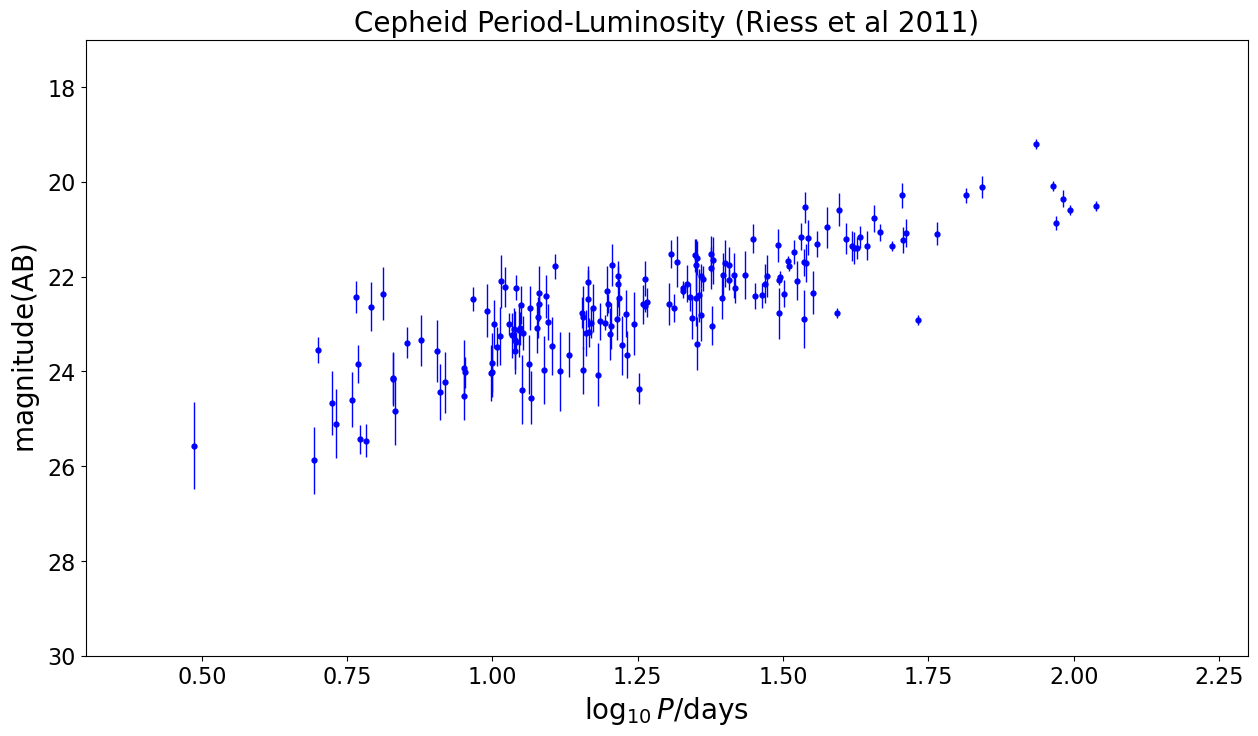

In [4]:
ceph.plot('4258')

<div style="color: DodgerBlue">

From this plot, I can see estimate the $\log P$-$m$ relationship for NGC4258 should have an intercept $zp_{\text{W},4258}\sim27$ and a slope $b_{\text{W}}\sim-3$. I set the priors for these parameters as wide uniform distributions including these values.

For each $\Delta\mu_{i}$, I set the prior as a normal distribution centered around a value computed by assuming $H_{0}=70\,\rm{km}\,\rm{s}^{-1}\,\rm{Mpc}^{-1}$. To prevent this prior from biasing the results, I use a fairly large width of $2.5$, which corresponds to half an order of magnitude. I also enforce $|\Delta\mu_{i}|<15$, which corresponds to differing distances by 3 orders of magnitude.

The prior distribution is summarized in the following table:

<center>

| Parameter            | Distribution                                   |
| :------------------: | :--------------------------------------------: |
| $\Delta\mu_{i}$      | $U(-15,15)\cdot N(\Delta\mu_{i,\text{est}},2.5)$ |
| $zp_{\text{W},4258}$ | $U(0,50)$                                      |
| $b_{\text{W}}$       | $U(-20,10)$                                    |

</center>

where
$$
\Delta\mu_{i,\text{est}}=5\log_{10}\left(\frac{cz_{i}}{H_{0}^{*}d_{4258}}\right),\qquad H_{0}^{*}=70\,{\rm{km}}\,{\rm{s}}^{-1}\,{\rm{Mpc}}^{-1},\qquad d_{4258}=7.6\,\rm{Mpc}.
$$
I obtain $d_{4258}$ from Humphreys et al. (2013), which is also referenced later in this assignment.

</div>

In [5]:
from scipy.stats import norm

rng = np.random.default_rng(42)


def log_prior(theta):
    *mu_diffs, PL_intercept_4258, b_W = theta
    
    for mu_diff in mu_diffs:
        if abs(mu_diff) > 15:
            return -np.inf
    
    # Assume a uniform prior on PL_intercept_4258 and b_W
    if (PL_intercept_4258 < 0 or 50 < PL_intercept_4258) or \
       (b_W < -20 or 10 < b_W):
        return -np.inf
    
    c = 2.998e5    # km/s
    d_4258 = 7.60  # Mpc, taken from Humphreys et al. 2013
    H0 = 70        # km/s/Mpc
    
    log_prior = 0
    
    # The prior on each distance modulus difference is set as a normal distribution with width 2.5 and
    #  centered around a value estimated by assuming H0 = 70 km/s/Mpc. So that the assumed value of H0
    #  does not have a significant impact on the results, I use a standard deviation of 2.5, which
    #  corresponds to a change in distance by half an order of magnitude.
    for (hostID, mu_diff) in zip(hosts[hosts != '4258'], mu_diffs):
        z = ceph.redshifts[hostID]
        mu_diff_est = 5 * np.log10(c * z / (H0 * d_4258))
        
        log_prior += np.log10(norm.pdf(mu_diff, loc=mu_diff_est, scale=2.5))
    
    return log_prior

# Q3. 

## Implement this likelihood and prior in python and sample the posterior distribution with emcee.

## Construct traceplots for each parameter, as well as corner plots for each pair of parameters.


## If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

## Compare the intercept you find for the intercepts $\mu_{0,i} - \mu_{0, 4258}$ vs Table 3 of Riess et al. 2011

In [6]:
def log_posterior(theta, sigma_int):
    return log_likelihood(theta, sigma_int) + log_prior(theta)

<div style="color: DodgerBlue">

I use 20 walkers and keep 10000 steps for each after 2000 steps of burn-in. I obtain estimates of the best-fit parameters with `scipy.optimize.minimize` and set the initial state of each walker by perturbing this set of parameter values. I take $\sigma_{\text{int}}=0.08$ as indicated in Table 3 of Riess et al. (2011).

</div>

In [7]:
import emcee
from scipy.optimize import minimize
import warnings

ndim = len(hosts) + 1
sigma_int = 0.08

# Fit model with scipy
x0 = (0,) * (ndim - 2) + (28, -3)
bounds = np.array([(-15, 15)] * (ndim - 2) + [(0, 50), (-20, 10)])
fit_result = minimize(lambda theta, *args: -log_likelihood(theta, *args), x0, args=(sigma_int,), bounds=bounds)
initial_guess = fit_result.x
uncertainties = np.abs(initial_guess) / 5

# MCMC properties
nwalkers = 20
burnin = 2000
nsteps = 10000

# Set initial state by perturbing from fit, also ensure that perturbed parameters are within parameter bounds
initial_state = rng.normal(initial_guess, uncertainties, (nwalkers, ndim))
for i in range(nwalkers):
    bad_inds = ((initial_state[i, :] < bounds[:, 0]) | (bounds[:, 1] < initial_state[i, :]))
    while np.any(bad_inds):
        initial_state[i, bad_inds] = rng.normal(initial_guess[bad_inds], uncertainties[bad_inds])
        bad_inds = ((initial_state[i, :] < bounds[:, 0]) | (bounds[:, 1] < initial_state[i, :]))

# Run MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(sigma_int,))
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    sampler.run_mcmc(initial_state, burnin, progress=True)
    sampler.reset()
    sampler.run_mcmc(None, nsteps, progress=True)
np.save('chain.npy', sampler.get_chain(flat=True))

100%|██████████| 10000/10000 [05:20<00:00, 31.24it/s]


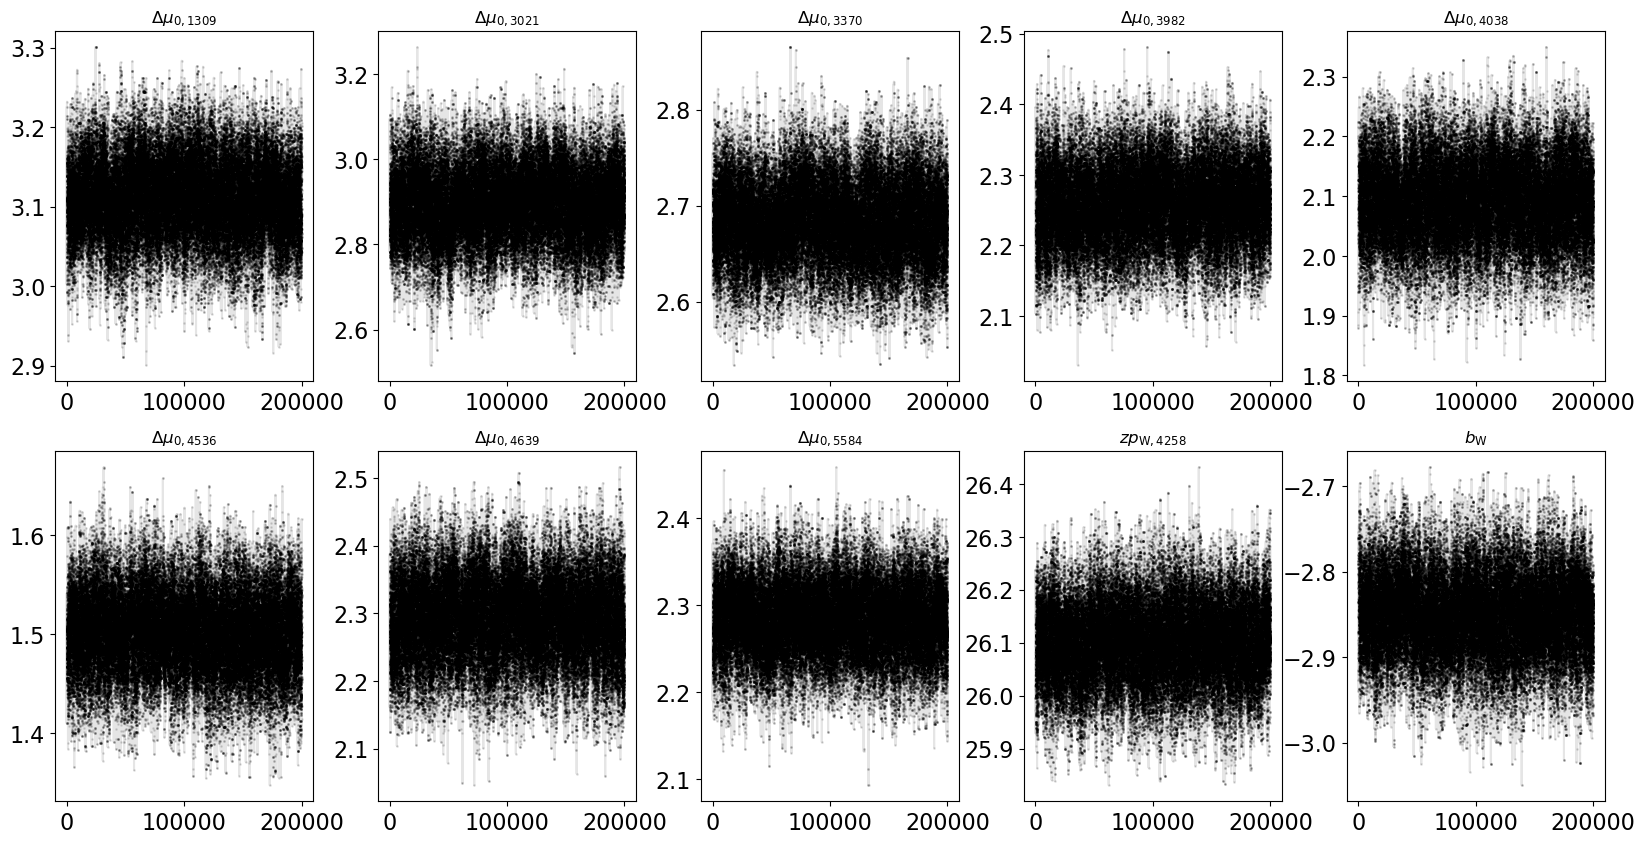

In [8]:
chain = np.load('chain.npy')

# Plot walkers
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.reshape(axes.size)
plt.subplots_adjust(wspace=0.25)

labels = [rf'$\Delta\mu_{{0,{host}}}$' for host in hosts if host != '4258'] + [r'$zp_{\rm{W},4258}$', r'$b_{\rm{W}}$']
for (i, (ax, label)) in enumerate(zip(axes, labels)):
    ax.set_title(label)
    ax.plot(chain[:, i], ls='-', c='Black', marker='.', markersize=2, alpha=0.1)

plt.savefig('plots/walkers.png')
plt.show()
plt.close(fig)

<div style="color: DodgerBlue">

The traceplots appear to be reasonable.

</div>

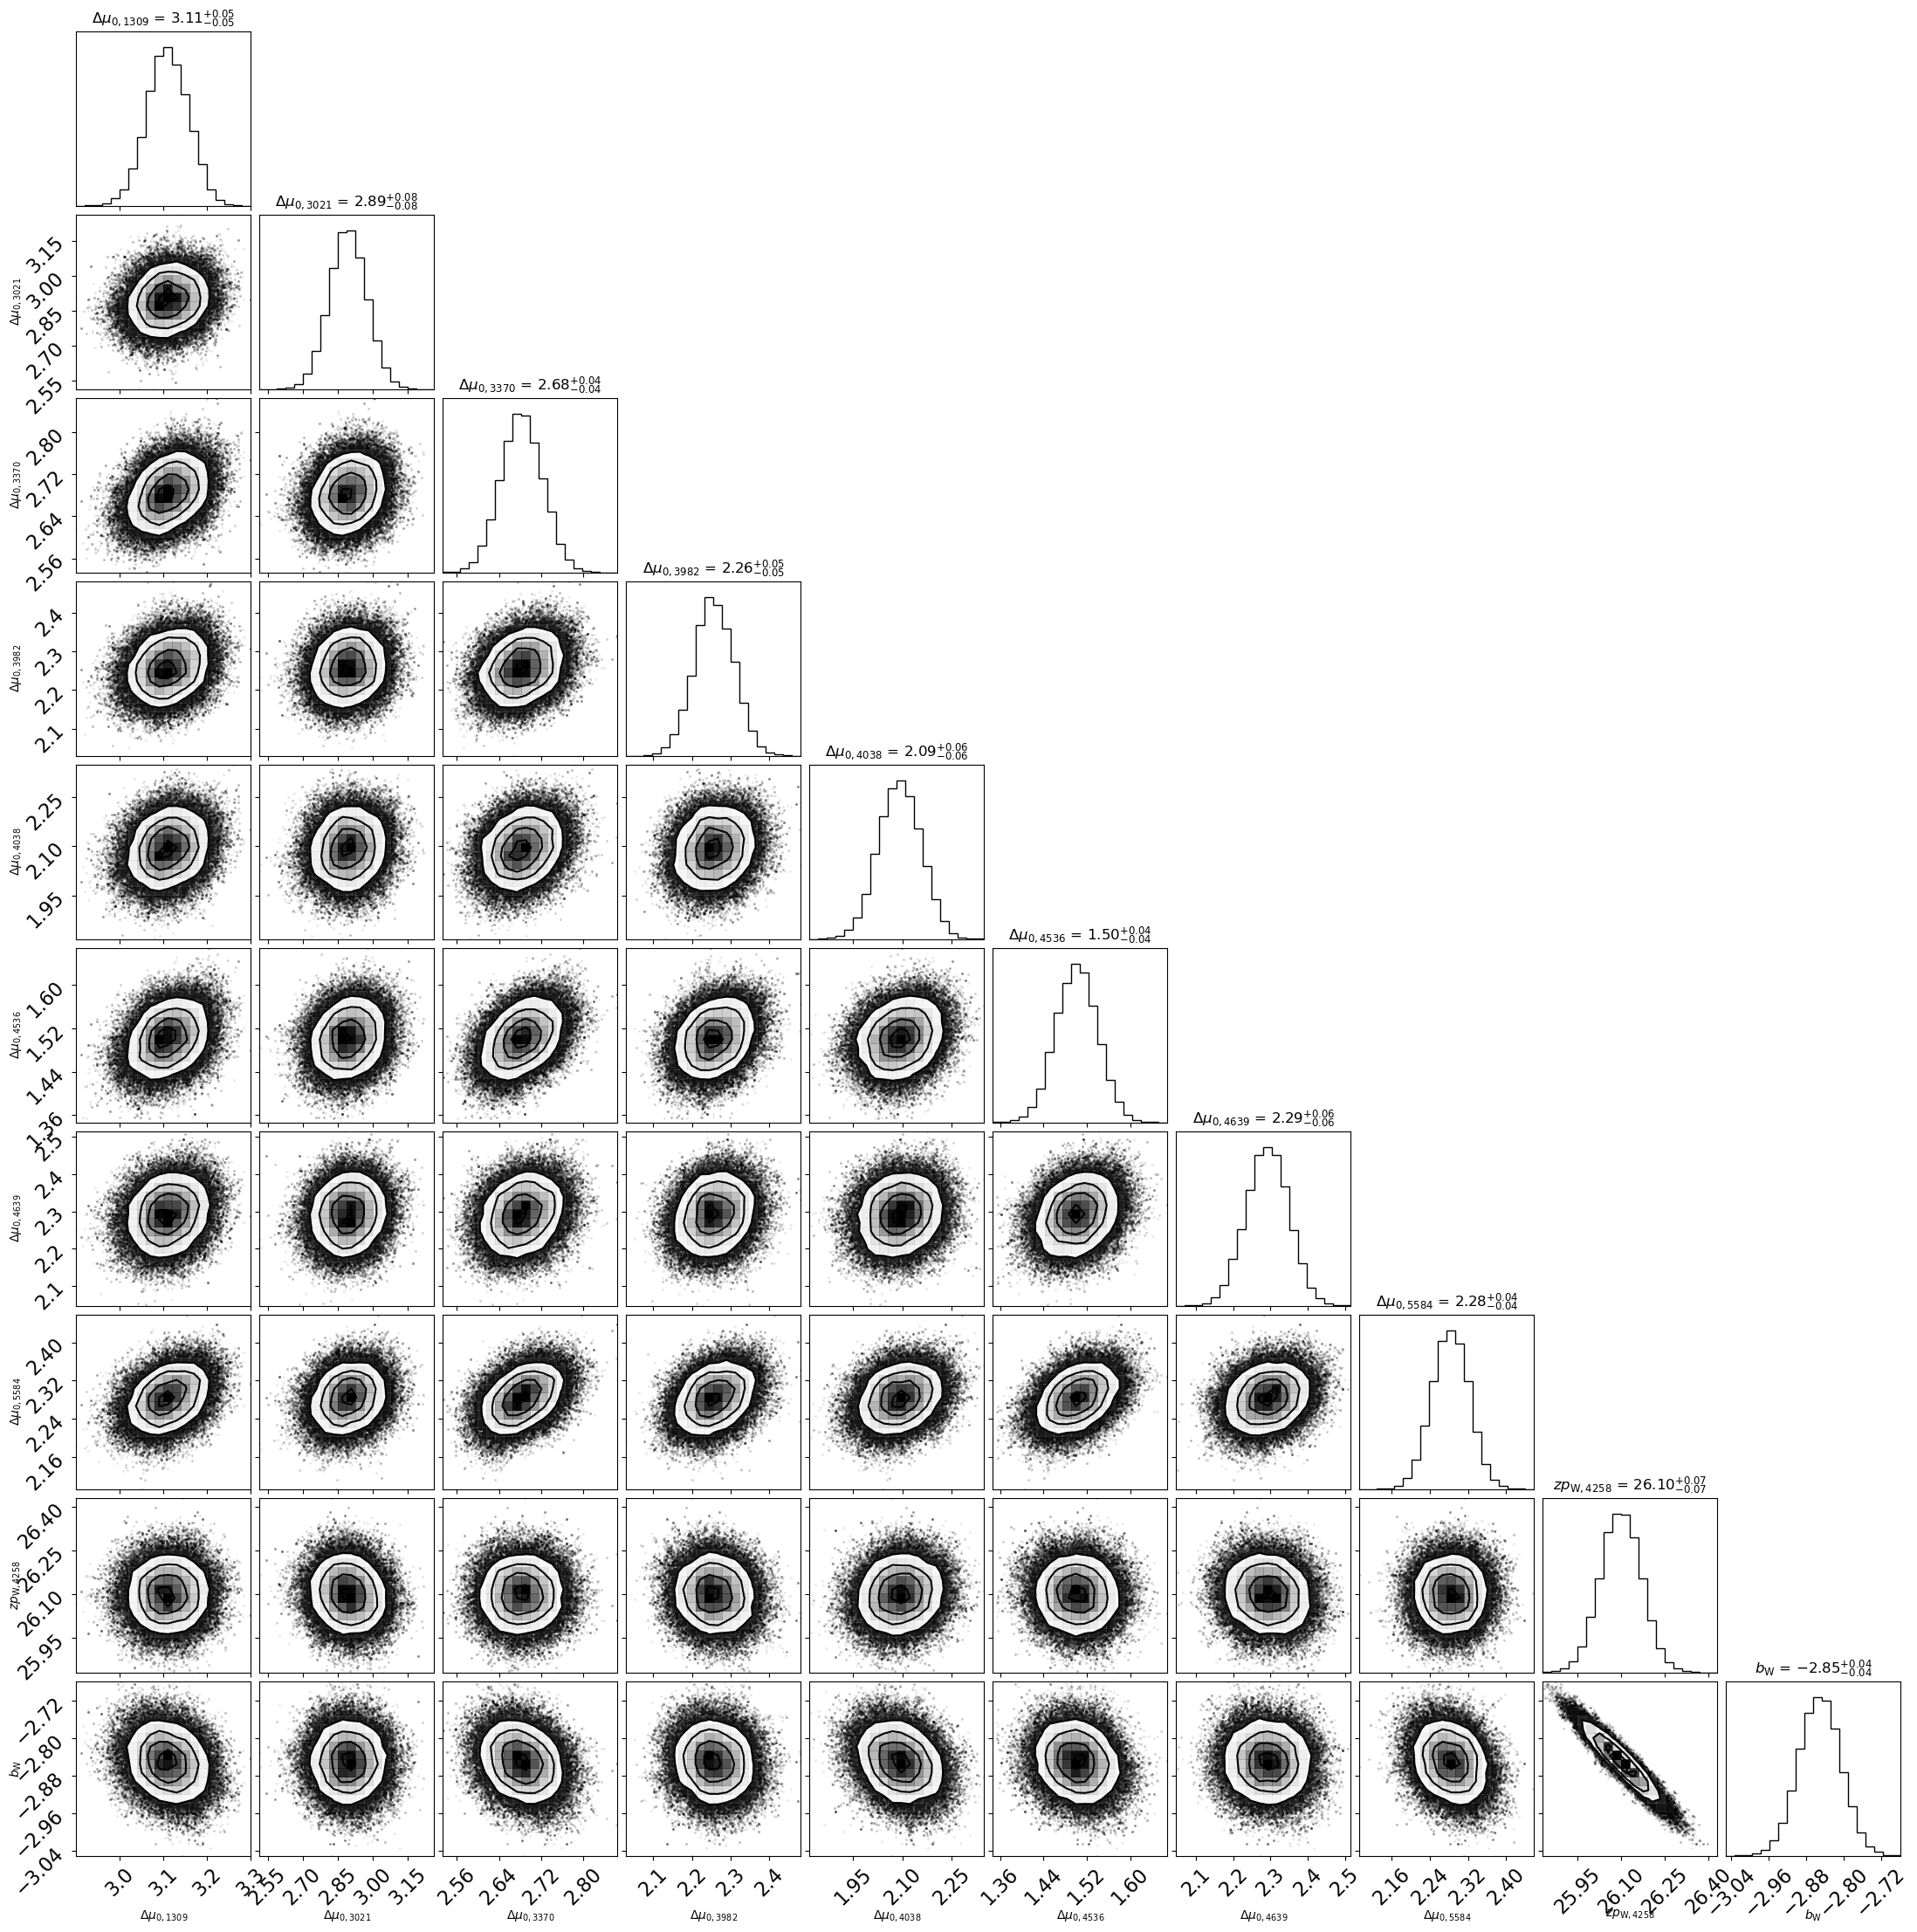

In [9]:
import corner

corner.corner(chain, labels=labels, show_titles=True)
plt.savefig('plots/corner.png')
plt.show()
plt.close()

<div style="color: DodgerBlue">

As seen from the above plots,
* $\Delta\mu_{i}$ generally have either no correlation or a weak positive correlation with each other,
* $\Delta\mu_{i}$ and $zp_{\text{W},4258}$ have roughly no correlation,
* $\Delta\mu_{i}$ and $b_{\text{W}}$ have either no correlation or a weak negative correlation, and
* $zp_{\text{W},4258}$ and $b_{\text{W}}$ have a strong negative correlation.

Non-positive correlations between $\Delta\mu_{i}$, $zp_{\text{W},4258}$, and $b_{\text{W}}$ are expected since increasing each of these quantitites has the effect of increasing the model magnitude. Non-negative correlations between $\Delta\mu_{i}$ are also expected as they all have non-positive correlations with $zp_{\text{W},4258}$ and $b_{\text{W}}$.

</div>

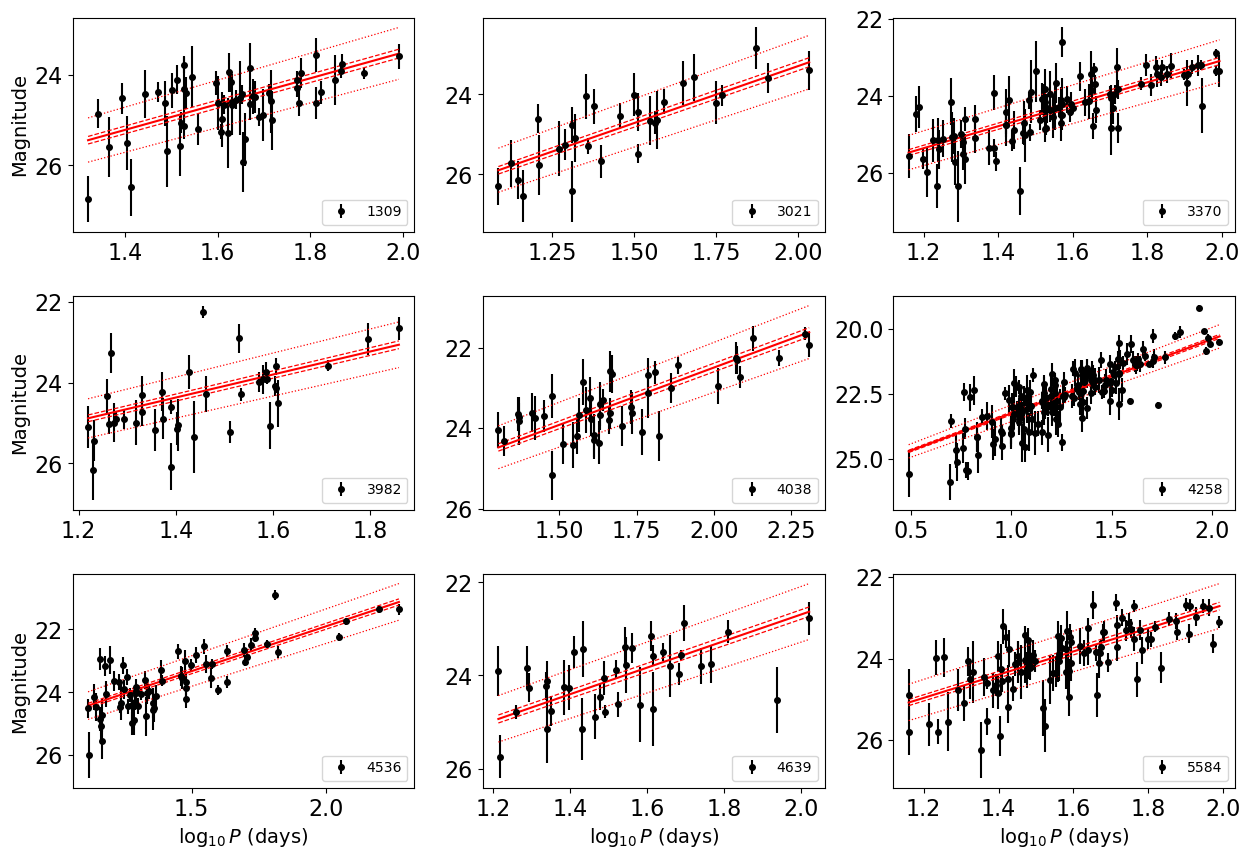

In [26]:
params = np.percentile(chain, [0.3, 32, 50, 68, 99.7], axis=0)

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.reshape(axes.size)
plt.subplots_adjust(hspace=0.3, wspace=0.2)

for ind in (0, 3, 6):
    axes[ind].set_ylabel('Magnitude', fontsize=14)
for ind in (6, 7, 8):
    axes[ind].set_xlabel('$\log_{10}P$ (days)', fontsize=14)

for ax in axes:
    ax.invert_yaxis()

i = 0
for (hostID, ax) in zip(hosts, axes):
    if hostID == '4258':
        mu_diff = np.full(5, 0)
    else:
        mu_diff = params[:, int(np.argwhere(hosts[hosts != '4258'] == hostID))]
    
    ceph.select(hostID)
    logP_plot = np.linspace(ceph.logP.min(), ceph.logP.max(), 100)
    ax.errorbar(ceph.logP, ceph.mobs, ceph.sigma, c='Black', ls='None', marker='o', markersize=4, label=hostID)
    ax.plot(logP_plot, model(logP_plot, mu_diff[2], params[2, -2], params[2, -1]), c='Red')
    ax.plot(logP_plot, model(logP_plot, mu_diff[1], params[1, -2], params[1, -1]), c='Red', ls='dashed', lw=0.9)
    ax.plot(logP_plot, model(logP_plot, mu_diff[3], params[3, -2], params[3, -1]), c='Red', ls='dashed', lw=0.9)
    ax.plot(logP_plot, model(logP_plot, mu_diff[0], params[0, -2], params[0, -1]), c='Red', ls='dotted', lw=0.9)
    ax.plot(logP_plot, model(logP_plot, mu_diff[4], params[4, -2], params[4, -1]), c='Red', ls='dotted', lw=0.9)
    ax.legend(loc='lower right')

plt.savefig('plots/model_fits.png')
plt.show()
plt.close(fig)

<div style="color: DodgerBlue">

In the above plots, the solid red line represents the best-fit (50th percentile) model, the dashed red lines represent the 32nd and 68th percentile ($\sim\pm1\sigma$) models, and the dotted red lines represent the 0.3th and 99.7th percentile ($\sim\pm3\sigma$) models. The model fits the bulk of the data fairly well. The presence of many outliers from the fits could imply that many data points have underestimated errors or that the model is incorrect/incomplete.

</div>

In [28]:
dmu_riess = np.array([3.276, 3.138, 2.835, 2.475, 2.396, 1.567, 2.383, 2.461])
line = 'Galaxy | Delta mu_i | Delta mu_i (Riess)'
print(line)
print('=' * len(line))
for (host, param, param_riess) in zip(hosts[hosts != '4258'], params[2, :], dmu_riess):
    print(' | '.join([host.center(6), f'{param:.4f}'.center(10), f'{param_riess:.4f}'.center(18)]))

Galaxy | Delta mu_i | Delta mu_i (Riess)
 1309  |   3.1103   |       3.2760      
 3021  |   2.8950   |       3.1380      
 3370  |   2.6835   |       2.8350      
 3982  |   2.2565   |       2.4750      
 4038  |   2.0926   |       2.3960      
 4536  |   1.5021   |       1.5670      
 4639  |   2.2923   |       2.3830      
 5584  |   2.2840   |       2.4610      


<div style="color: DodgerBlue">

The values obtained for $\Delta\mu_{i}$ in Riess et al. (2011) are all larger than the values I obtain. This could be accounted for if they obtain a smaller $zp_{\text{W},4258}$ or $b_{\text{W}}$, or possibly by the exclusion of metallicity from the model considered here. However, I was unable to find any information about the fitted values of $zp_{\text{W},4258}$ or $b_{\text{W}}$ in the paper.

</div>

# Q4.

## Riess et al. do a *simultaneous* fit to the Cepheids and SNe data (Table 3 of their paper). 

## I'm slightly less cruel, so you can take your intercepts $\mu_{0,i} - \mu_{0, 4258}$ and the re-express equation 4 using a substitution of equation 3.

## Write that expression down.

<div style="color: DodgerBlue">

An estimate of the Hubble constant for the $i$-th host galaxy is given by

$$
\log_{10}H_{0,i}=\frac{(m_{v,4258,i}^{0}-\mu_{0,4258})+5a_{v}+25}{5}=\frac{(m_{v,i}^{0}+5a_{v})-(\mu_{0,i}-\mu_{0,4258})-\mu_{0,4258}+25}{5}.
$$

</div>

# Q5

## Using the supernova data in Table 3 (enter it into whatever data structure you deem best) and the distance intercept to NGC 4258 from [Humphreys et al., 2013 ](https://ui.adsabs.harvard.edu/abs/2013ApJ...775...13H/abstract) and using the simple sample statistics you learned in Week 1, estimate the Hubble constant.

<div style="color: DodgerBlue">

Given the values of $m_{v,i}^{0}+5a_{v}$ from Table 3, I can estimate the Hubble constant for each step of the chain. I can then obtain an overall estimate and uncertainty by taking the median and standard deviation of these values across the chain.

</div>

In [21]:
#                   '1309'  '3021'  '3370'  '3982'  '4038'  '4536'  '4639'  '5584'
mag_5av = np.array([16.768, 16.699, 16.545, 15.953, 15.901, 15.147, 16.040, 16.274])

d_4258 = 7.60  # Mpc
mu_4258 = 5 * np.log10(d_4258) + 25

logH0 = (mag_5av - chain[:, :-2] - mu_4258 + 25) / 5
print(np.median(10**logH0))
print(np.std(10**logH0))

74.3466214633294
4.218940872265999


<div style="color: DodgerBlue">

I obtain $H_{0}\approx74.35\pm4.22\,\rm{km}\,\rm{s}^{-1}\,\rm{Mpc}^{-1}$, which is consistent with the value obtained in the paper.

</div>